# Computer Vision HT 2025 - Practical 3 (v1.1)

## Instructions

1. Start Google Colab: https://colab.research.google.com. A modal dialog should have appeared to open a new notebook. If not, go to "File>Open notebook".
2. From the open notebook dialog, select the GitHub "tab" and enter this URL: https://github.com/chrirupp/cv_course
3. The notebook(s) should appear (*.ipynb). Select the one for the current practical.
4. To run a notebook on Colab you will typically need some data files (e.g., images). As Colab only loads the notebook itself, these other files need to be downloaded separately. The following cell is a `%%sh` block that downloads the required files. You can inspect the downloaded files by clicking on the "Files" tab on the left.

## Practicalities

The signing-off happens in the last half hour of each session or at the beginning of the following one.
As usual, when checking your work the demonstrator will want to see a working version of the program in action, as well as appropriate comments of your code. Try to make your report as concise as possible, perhaps in the form of appropriate comments to your code.

Since this is a new practical task, any errors, ambiguities or suggestions for improvement should be flagged as soon as possible.

If you are not familiar with the way practicals run, there are department-wide [rules](https://www.cs.ox.ac.uk/teaching/courses/2023-2024/practicals/). There you will find how the compulsory part, the optional tasks, and your report will factor into your mark.

## Advice

* You will need to look at the code for the lectures. There you will find many related computations that you can reuse and adapt to solve the practicals.
* The compulsory part of this practical is designed to give you additional understanding of the concepts taught in the lectures. It should be achievable in one session.

Here we import some libraries that we will need to process images, do maths, and to visualise results.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import json
from torchvision import transforms
from tqdm import tqdm
from torchvision import datasets, transforms
from IPython.display import display, clear_output
%matplotlib inline

The usual set of helper functions:

In [8]:
# Download the data - you need to do this only once
!wget --no-verbose --output-document=./data/coco_bboxes.json https://github.com/chrirupp/cv_course/raw/main/data/coco_bboxes.json

2025-03-06 13:35:20 URL:https://raw.githubusercontent.com/chrirupp/cv_course/main/data/coco_bboxes.json [59457/59457] -> "./data/coco_bboxes.json" [1]


In [9]:
class Visualizer():
    def __init__(self, num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='', tight=False, cm=None):
        self.fig, self.axs = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
        # remove ticks
        if axis_off:
          plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        # set colormap
        if cm is not None:
            plt.set_cmap(cm)
        # set supertitle
        self.fig.suptitle(title)
        if tight:
            self.fig.subplots_adjust(top=0.88)

    def add_image_subplot(self, i, j, image, normalize=False, title_str=''):
        if normalize:
            image = self.normalize_image(image)
        if len(image.shape) == 3:
            #BGR -> RGB
            image = image[:, :, ::-1]
        self.axs[i, j].imshow(image)
        self.axs[i, j].set_title(title_str)

    def show(self):
        display(self.fig)
        clear_output(wait = True)
        plt.pause(0.05)

    def add_stem_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].stem(x, y)
        self.axs[i, j].set_title(title_str)

    def add_subplot(self, i, j, data, title_str=''):
        self.axs[i, j].plot(data)
        self.axs[i, j].set_title(title_str)

    def add_subplot_xy(self, i, j, x, y, title_str=''):
        self.axs[i, j].plot(x,y)
        self.axs[i, j].set_title(title_str)

    def add_bar_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].bar(x, y)
        self.axs[i, j].set_title(title_str)

    @staticmethod
    def normalize_image(image):
        img = np.float64(image) - np.min(image)
        img /= np.max(img)
        return img

## Problem 3.1 - Object Detection

Let us build an evaluation function for an object detector. Assume that for each image we are given bounding boxes by their top-left $(x_1,y_1)$ and bottom-right $(x_2,y_2)$ together with a confidence $c \in \mathbb{R}^C$.

We will start by computing the intersection over union of two boxes.
Hint: the area of the union of two boxes can also be computed as: area1 + area2 - intersection.

Careful: a box $(x_1,y_1) = (x_2,y_2)$ has a area of 1 pixel because it includes this pixel!

In [10]:
def iou(box1, box2):
    # Extract coordinates for both boxes, ignoring the class confidence (c)
    x1_1, y1_1, x2_1, y2_1, _ = box1
    x1_2, y1_2, x2_2, y2_2, _ = box2

    # Compute the (x, y)-coordinates of the intersection rectangle
    x_left = max(x1_1, x1_2)
    y_top = max(y1_1, y1_2)
    x_right = min(x2_1, x2_2)
    y_bottom = min(y2_1, y2_2)

    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No intersection

    # Calculate the area of intersection
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    # Calculate the area of both bounding boxes
    area1 = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
    area2 = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)

    # Compute the area of union
    union_area = area1 + area2 - intersection_area

    # Compute the IoU
    iou = intersection_area / union_area

    return iou


# test the iou function
box1 = (50, 50, 100, 100, 1.0)
box2 = (60, 60, 110, 110, 1.0)
box3 = (101, 101, 105, 105, 0.5)
print(iou(box1, box1))  # should be 1
print(iou(box1, box3))  # should be 0
print(iou(box1, box2))  # should be ca. 0.4774
print(iou(box2, box3))  # should be ca. 0.0096

1.0
0.0
0.47742118716273785
0.009611687812379853


Let us now compute the precision and recall for a given confidence threshold. For this problem we will load some real predictions and GT annotations from `coco_bboxes.json`.
This is a real file from a model we are currently researching. We have reduced this file to only a few images and only a single class "person" to make this exercise easier.

You are loading a nested data structure of the following form:

* The data is given as a list of images `[image]`.
* Each image is a dictionary with three elements:
  * `image["image_id"]` is the filename of the image - you can ignore this.
  * `image["gt_boxes"]` is as list of ground truth boxes $(x,y,w,h) \in mathbb{R}^4$.
  * `image["pred_boxes"]` is as list of predictions $(\hat{x},\hat{y},\hat{w},\hat{h},\hat{c}) \in mathbb{R}^5$.

All coordinates and sizes have been normalised by their respective image size, so that you do not need to take this into account.
We are again looking only at a single class, thus predictions only have a scalar confidence and GT boxes do not have a class at all.

Write a function that computes the IoU between each predicted and GT box in an image

In [11]:
def compute_ious(gt_boxes, pred_boxes):
    ious = np.zeros((len(gt_boxes), len(pred_boxes)))

    for i, gt_box in enumerate(gt_boxes):
        # Convert GT box format (x, y, w, h) to (x1, y1, x2, y2)
        x, y, w, h = gt_box
        gt_box_coords = (x, y, x + w, y + h, 1.0)  # Confidence is not relevant for GT

        for j, pred_box in enumerate(pred_boxes):
            # Convert predicted box format (x, y, w, h, c) to (x1, y1, x2, y2, c)
            x, y, w, h, c = pred_box
            pred_box_coords = (x, y, x + w, y + h, c)

            # Calculate IoU for the pair and store in matrix
            ious[i, j] = iou(gt_box_coords, pred_box_coords)

    return ious

# load the file
with open('./data/coco_bboxes.json', 'r') as f:
    data = json.load(f)

print(compute_ious(data[0]['gt_boxes'], data[0]['pred_boxes']))  # you should see how the predictions and gt boxes will likely match

[[0.99218795 0.         0.        ]
 [0.         0.99464379 0.86090906]]


We will now precompute the IoU scores for each image, so that we can later quickly evaluate different thresholds.
For the greedy matching in the next step, we need to sort the predicted boxes by decreasing confidence before computing IoU.
make sure to update the `data` so that the sorting of IoUs matches the data.

In [12]:
def compute_all_ious(data):
    all_ious = []

    for image in data:
        # Sort predicted boxes by confidence in descending order
        sorted_pred_boxes = sorted(image['pred_boxes'], key=lambda x: x[-1], reverse=True)

        # Update the data with sorted predicted boxes to keep it consistent for later use
        image['pred_boxes'] = sorted_pred_boxes

        # Compute IoUs for the sorted predicted boxes
        ious = compute_ious(image['gt_boxes'], sorted_pred_boxes)
        all_ious.append(ious)

    return all_ious

all_ious = compute_all_ious(data)
print(all_ious[1])  # for the second image, you should see that each gt has an almost perfectly matching prediction

[[0.         0.99726976 0.        ]
 [0.         0.         0.99708323]
 [0.99553852 0.         0.        ]]


Now to compute the TP, FP, FN for an image, we perform greedy matching between GT boxes and predictions.
You will need to keep a lookup table if a GT box had already been matched.
Iterate over all predicted boxes in decreasing confidence, discarding boxes below the confidence threshold.
Now, for each predicted box, find the GT box with highest overlap that has not been matched.
Count the best match as TP if it is $\ge$ than the IoU threshold.

Your function should return TP, Fp and FN counts.

In [13]:
def compute_tp_fp_fn(ious, pred_boxes, th_confidence, th_iou):
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = ious.shape[0]  # False Negatives start as all GT boxes

    # Create a lookup table to keep track of matched GT boxes
    matched_gt = [False] * ious.shape[0]

    # Iterate over predicted boxes sorted by confidence
    for j, pred_box in enumerate(pred_boxes):
        if pred_box[-1] < th_confidence:
            continue  # Skip predictions below confidence threshold

        # Find the GT box with the highest IoU that has not been matched
        best_iou = 0
        best_gt_idx = -1
        for i in range(ious.shape[0]):
            if not matched_gt[i] and ious[i, j] > best_iou:
                best_iou = ious[i, j]
                best_gt_idx = i

        # Evaluate the best match
        if best_gt_idx != -1 and best_iou >= th_iou:
            # Valid match found
            tp += 1
            matched_gt[best_gt_idx] = True  # Mark this GT box as matched
            fn -= 1  # Reduce false negatives since a match was found
        else:
            # No valid match found, count as false positive
            fp += 1

    return tp, fp, fn

# test the function
tp, fp, fn = compute_tp_fp_fn(all_ious[0], data[0]['pred_boxes'], 0.0, 0.5)
print(tp, fp, fn)  # you should see 2 1 0 for confidence 0.0 and iou 0.5

2 1 0


We now need to accumulate TP, FP, FN across the evaluation dataset to compute precision and recall.

In [14]:
def precision_recall(all_ious, data, th_confidence, th_iou):
    tp = 0  # Total true positives
    fp = 0  # Total false positives
    fn = 0  # Total false negatives
    total_predictions = 0  # To track if there are any predictions left

    # Accumulate TP, FP, FN for each image
    for i, image in enumerate(data):
        # Count the number of predictions above the confidence threshold
        valid_predictions = [box for box in image['pred_boxes'] if box[-1] >= th_confidence]
        total_predictions += len(valid_predictions)

        image_tp, image_fp, image_fn = compute_tp_fp_fn(all_ious[i], image['pred_boxes'], th_confidence, th_iou)
        tp += image_tp
        fp += image_fp
        fn += image_fn

    # Handle case where no predictions are above the confidence threshold
    if total_predictions == 0:
        precision = 1.0  # No false positives if there are no predictions
        recall = 0.0     # No objects detected, so recall is 0
    else:
        # Compute precision and recall normally
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return precision, recall

# test the function
precision, recall = precision_recall(all_ious, data, 0.0, 0.5)
print(precision, recall)  # about 0.52 and 0.94

0.5103626943005182 0.9205607476635514


Plot a precision-recall curve for our detector by iterating over 100 confidence thresholds between 0 and 1.
You might need to modify your code above to deal with situations where a high confidence threshold eliminates all predictions.

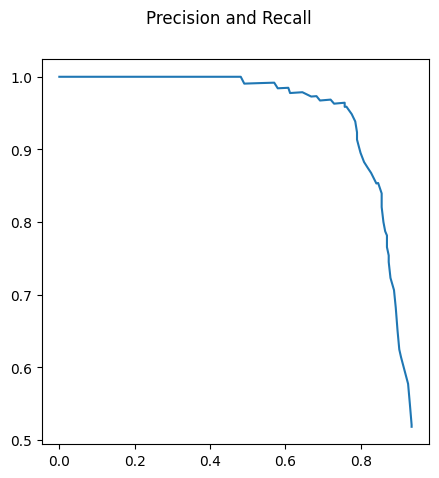

In [15]:
precision_values = []
recall_values = []

# TODO: fill precision/recall lists
for th_confidence in np.linspace(0, 1, 100):
    precision, recall = precision_recall(all_ious, data, th_confidence, 0.2)
    precision_values.append(precision)
    recall_values.append(recall)

viz = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=False, title='Precision and Recall', tight=True)
viz.add_subplot_xy(0, 0, recall_values, precision_values)


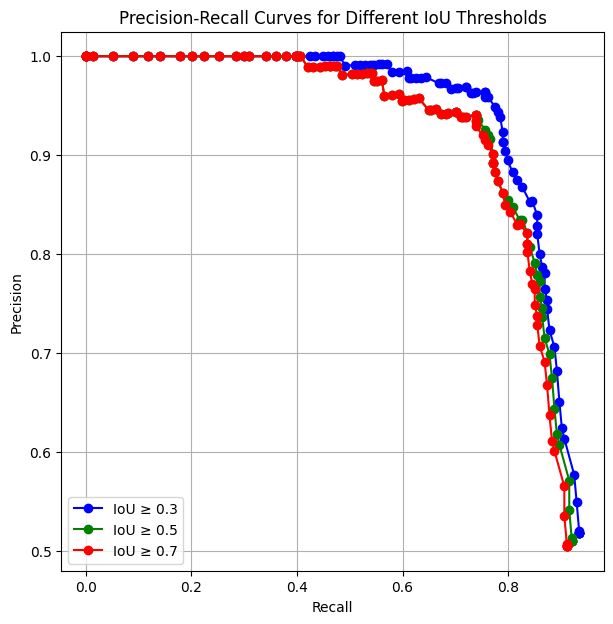

In [16]:
import matplotlib.pyplot as plt
import numpy as np

iou_thresholds = [0.3, 0.5, 0.7]  # Different IoU thresholds to test
colors = ['b', 'g', 'r']  # Colors for different curves

plt.figure(figsize=(7, 7))

# Plot PR curves for each IoU threshold
for idx, th_iou in enumerate(iou_thresholds):
    precision_values = []
    recall_values = []

    for th_confidence in np.linspace(0, 1, 100):
        precision, recall = precision_recall(all_ious, data, th_confidence, th_iou)
        precision_values.append(precision)
        recall_values.append(recall)

    plt.plot(recall_values, precision_values, marker='o', linestyle='-', color=colors[idx], label=f'IoU ≥ {th_iou}')

# Customize the plot
plt.title('Precision-Recall Curves for Different IoU Thresholds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()


Analyse the PR curve for several IoU thresholds.
* What can you tell about our detector?

### Optional Task - overconfidence is a slow and insidious killer
Another way to analyse the quality of the confidence prediction is to plot a scatter plot using all predicted boxes. The the x-axis is the confidence, while the y-axis is the IoU with the best matching GT box. If this plot is close to a line (x=y), the confidence correlated with the expected GT box overlap.
Create this plot and draw some conclusions.

### Optional Task - Scaling up the evaluation
Download `coco_bboxes_full.json` and extend your evaluation code to handle multiple classes. Average precision and recall across all 80 classes of the COCO dataset.

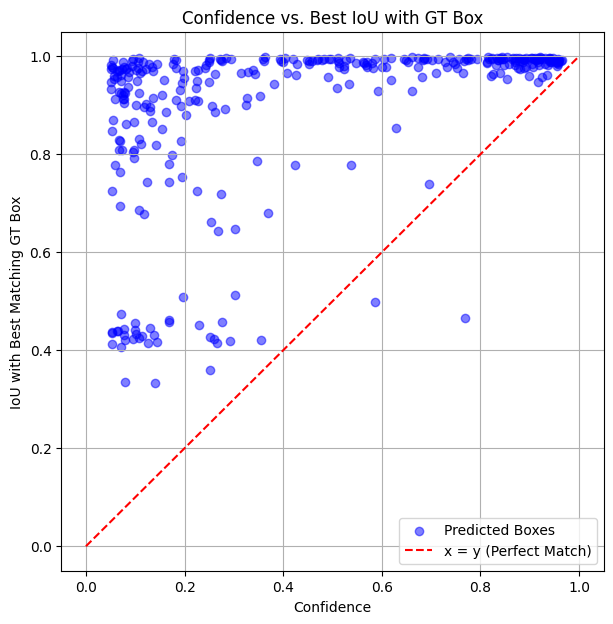

In [17]:
import matplotlib.pyplot as plt

# Prepare data for scatter plot
confidences = []  # x-axis: Confidence scores of predicted boxes
ious_with_best_gt = []  # y-axis: IoUs with the best matching GT box

# Iterate over all images
for i, image in enumerate(data):
    ious = all_ious[i]
    pred_boxes = image['pred_boxes']

    for j, pred_box in enumerate(pred_boxes):
        confidence = pred_box[-1]  # Confidence score of the predicted box

        # Find the best IoU with any GT box for this predicted box
        best_iou = 0
        for iou_value in ious[:, j]:
            if iou_value > best_iou:
                best_iou = iou_value

        # Only consider predictions with a positive IoU
        if best_iou > 0:
            confidences.append(confidence)
            ious_with_best_gt.append(best_iou)

# Create scatter plot
plt.figure(figsize=(7, 7))
plt.scatter(confidences, ious_with_best_gt, alpha=0.5, color='blue', label='Predicted Boxes')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='x = y (Perfect Match)')
plt.title('Confidence vs. Best IoU with GT Box')
plt.xlabel('Confidence')
plt.ylabel('IoU with Best Matching GT Box')
plt.grid(True)
plt.legend()
plt.show()


In [18]:
import json

# Load the full COCO dataset with multiple classes
with open('coco_bboxes_full.json', 'r') as f:
    full_data = json.load(f)


def compute_tp_fp_fn(ious, pred_boxes, gt_boxes, th_confidence, th_iou):
    tp = 0
    fp = 0
    fn = 0

    # Create lookup for matched GT boxes by class
    matched_gt = {cls: [False] * len([box for box in gt_boxes if box[-1] == cls]) for cls in range(80)}

    # Iterate over predicted boxes sorted by confidence
    for j, pred_box in enumerate(pred_boxes):
        if pred_box[-2] < th_confidence:
            continue  # Skip predictions below confidence threshold

        pred_class = pred_box[-1]
        best_iou = 0
        best_gt_idx = -1

        # Find the best matching GT box for the predicted class
        for i, gt_box in enumerate(gt_boxes):
            if gt_box[-1] != pred_class:
                continue  # Skip if GT box is not the same class

            if not matched_gt[pred_class][i] and ious[i, j] > best_iou:
                best_iou = ious[i, j]
                best_gt_idx = i

        if best_gt_idx != -1 and best_iou >= th_iou:
            tp += 1
            matched_gt[pred_class][best_gt_idx] = True  # Mark as matched
        else:
            fp += 1

    # Count unmatched GT boxes for false negatives
    for cls in matched_gt:
        fn += sum(1 for matched in matched_gt[cls] if not matched)

    return tp, fp, fn


def compute_all_ious(data):
    all_ious = []

    for image in data:
        sorted_pred_boxes = sorted(image['pred_boxes'], key=lambda x: x[-2], reverse=True)
        image['pred_boxes'] = sorted_pred_boxes

        # Convert GT and predicted boxes to (x1, y1, x2, y2, c, class)
        gt_boxes = [(x, y, x + w, y + h, 1.0, cls) for x, y, w, h, cls in image['gt_boxes']]
        pred_boxes = [(x, y, x + w, y + h, c, cls) for x, y, w, h, c, cls in sorted_pred_boxes]

        ious = compute_ious(gt_boxes, pred_boxes)
        all_ious.append(ious)

    return all_ious


def precision_recall(all_ious, data, th_confidence, th_iou):
    class_precisions = []
    class_recalls = []

    for cls in range(80):  # Assuming 80 classes
        tp = 0
        fp = 0
        fn = 0

        # Accumulate TP, FP, FN for each class
        for i, image in enumerate(data):
            gt_boxes = [box for box in image['gt_boxes'] if box[-1] == cls]
            pred_boxes = [box for box in image['pred_boxes'] if box[-1] == cls]

            if not gt_boxes and not pred_boxes:
                continue  # Skip if no GT or predictions for this class

            image_tp, image_fp, image_fn = compute_tp_fp_fn(all_ious[i], pred_boxes, gt_boxes, th_confidence, th_iou)
            tp += image_tp
            fp += image_fp
            fn += image_fn

        # Compute precision and recall per class
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        class_precisions.append(precision)
        class_recalls.append(recall)

    # Average precision and recall across all classes
    avg_precision = sum(class_precisions) / len(class_precisions)
    avg_recall = sum(class_recalls) / len(class_recalls)

    return avg_precision, avg_recall


all_ious = compute_all_ious(full_data)
avg_precision, avg_recall = precision_recall(all_ious, full_data, 0.0, 0.5)
print(f"Average Precision: {avg_precision:.2f}, Average Recall: {avg_recall:.2f}")


FileNotFoundError: [Errno 2] No such file or directory: 'coco_bboxes_full.json'

## Problem 3.2 - Diffusion Models

We will now train a tiny diffusion model on the car images in CIFAR 10. The architecture is a small U-Net:

In [24]:
class Model(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(128, 32, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
        ])
        self.final_conv1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.final_conv2 = nn.Conv2d(16, out_channels, kernel_size=3, padding=1)
        self.act = nn.LeakyReLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, timestep):
        skips = []
        for i, layer in enumerate(self.down_layers):
            x = self.act(layer(x))
            if i < 2:
              skips.append(x)
              x = self.downscale(x)

        for i, layer in enumerate(self.up_layers):
            if i > 0:
              x = self.upscale(x)
              x = torch.concatenate( [x, skips.pop()], axis=1)
            x = self.act(layer(x))

        x = self.act(self.final_conv1(x))
        x = self.final_conv2(x)
        return x

**Task:** Draw a diagram of the U-Net architecture to understand the connections within the network.

We will now load and filter the dataset to contain only cars (class_id = 1). You can use `torch.utils.data.Subset` to obtain a subset of a dataset.

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# TODO: filter training imgs
car_indices = [i for i, label in enumerate(cifar_train.targets) if label == 1]
cifar_train_reduced = torch.utils.data.Subset(cifar_train, car_indices)


BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(cifar_train_reduced, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


We will now need to compute a noise schedule. We will precompute the schedule and some useful values to reuse them later.
There are three parameters we will get to define the schedule $\beta_1, \beta_2$ and $T$.
$T$ is the number of steps (we will use 1000)
$\beta_1$ and $\beta_2$ define the start and end of th enoise schedule.

Define a vector $\beta_t$ for $t \in \{ 0, T \} that starts with $\beta_1$ and ends with $\beta_2$. Make sure that $\beta_t = \beta_1$ for $t=0$ and $\beta_t = \beta_2$ for $t=T$. ($T+1$ values).
Also precomupte the following values:
* $\sqrt{\beta_t}$
* $\alpha_t = 1 - \beta_t$
* $\bar{\alpha}_t = \prod_{i=0}^t \alpha_i$
* $\sqrt{\bar{\alpha}_t}$
* $\frac{1}{\sqrt{\alpha_t}}$
* $\sqrt{1 - \bar{\alpha}_t}$
* $\frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}}$

Then use the following formula to show examples of an image being noise through forward diffusion: $ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$, where $\epsilon \sim \mathcal{N}(0,1)$.

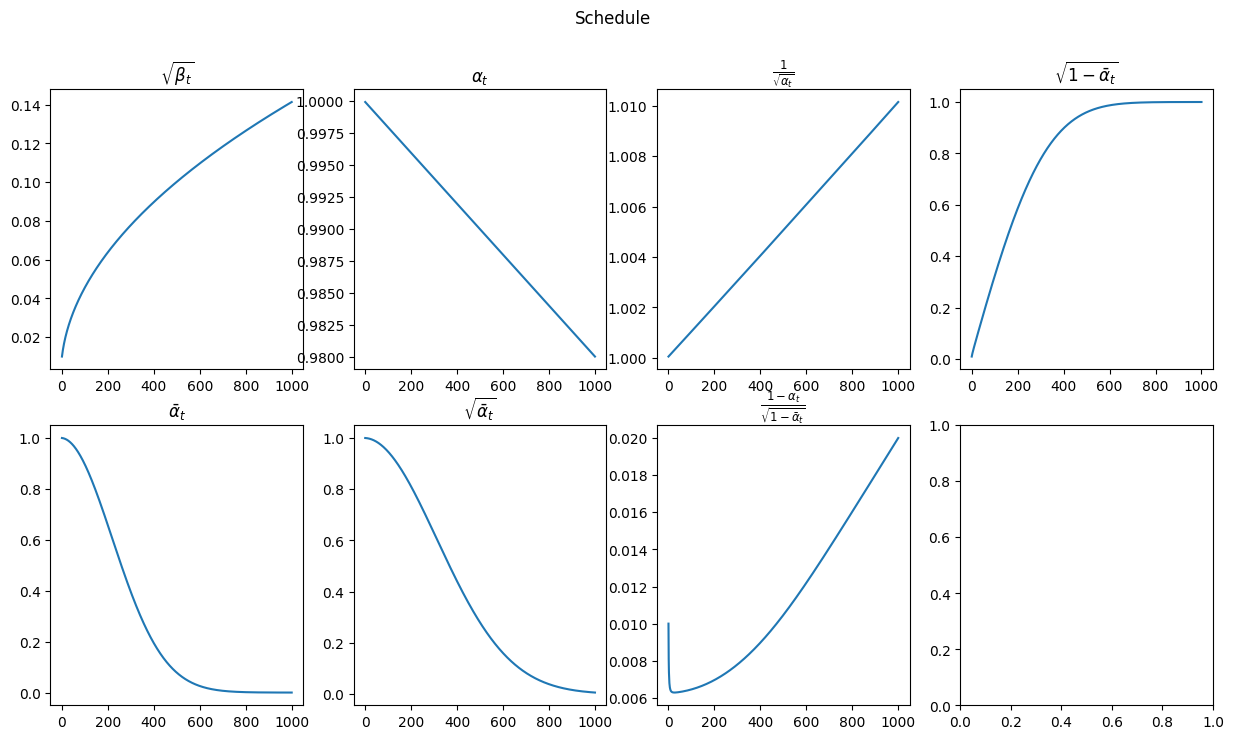

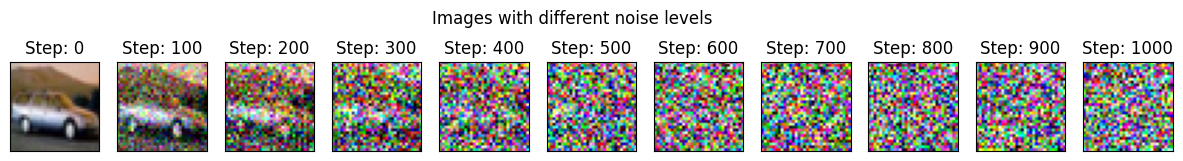

In [20]:
class Schedule():
    def __init__(self, beta1, beta2, T, device="cpu"):
        super().__init__()
        self.device = device
        self.num_steps = T

        # Create beta_t vector from beta1 to beta2
        self.beta_t = torch.linspace(beta1, beta2, T + 1, device=device)

        # Precompute values for all timesteps
        self.sqrt_beta_t = torch.sqrt(self.beta_t)
        self.alpha_t = 1 - self.beta_t
        self.alphabar_t = torch.cumprod(self.alpha_t, dim=0)
        self.sqrtab = torch.sqrt(self.alphabar_t)
        self.oneover_sqrta = 1 / torch.sqrt(self.alpha_t)
        self.sqrtmab = torch.sqrt(1 - self.alphabar_t)
        self.mab_over_sqrtmab_inv = (1 - self.alpha_t) / self.sqrtmab



# show images with different noise levels
schedule = Schedule(1e-4, 0.02, 1000)

# plot the schedule
vis = Visualizer(num_rows=2, num_cols=4, figsize=(15, 8), axis_off=False, title='Schedule')
vis.add_subplot(0, 0, schedule.sqrt_beta_t, title_str=r'$\sqrt{\beta_t}$')
vis.add_subplot(0, 1, schedule.alpha_t, title_str=r'$\alpha_t$')
vis.add_subplot(1, 0, schedule.alphabar_t, title_str=r'$\bar{\alpha}_t$')
vis.add_subplot(1, 1, schedule.sqrtab, title_str=r'$\sqrt{\bar{\alpha}_t}$')
vis.add_subplot(0, 2, schedule.oneover_sqrta, title_str=r'$\frac{1}{\sqrt{\alpha_t}}$')
vis.add_subplot(0, 3, schedule.sqrtmab, title_str=r'$\sqrt{1 - \bar{\alpha}_t}$')
vis.add_subplot(1, 2, schedule.mab_over_sqrtmab_inv, title_str=r'$\frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}}$')

vis = Visualizer(num_rows=1, num_cols=11, figsize=(15, 2), axis_off=True, title='Images with different noise levels')
for i in range(11):
    img, _ = cifar_train_reduced[0]
    noise = torch.randn(img.shape)
    step = i * (schedule.num_steps // 10)

    # Compute noised sample using forward diffusion
    step = i * (schedule.num_steps // 10)
    sqrtab = schedule.sqrtab[step]
    sqrtmab = schedule.sqrtmab[step]
    img = sqrtab * img + sqrtmab * noise

    # normalise for display
    img = (img + 1) / 2
    img = img.clip(0, 1)
    img = img.permute(1, 2, 0)
    vis.add_image_subplot(0, i, img.numpy(), title_str=f'Step: {step}')

We now need a function that given a batch of images and timesteps, produces input-output pairs. Each input will be noised with the corresponding timestep, while the target should be the corresponding noise. Make sure that the returned vector of timesteps is a float32.

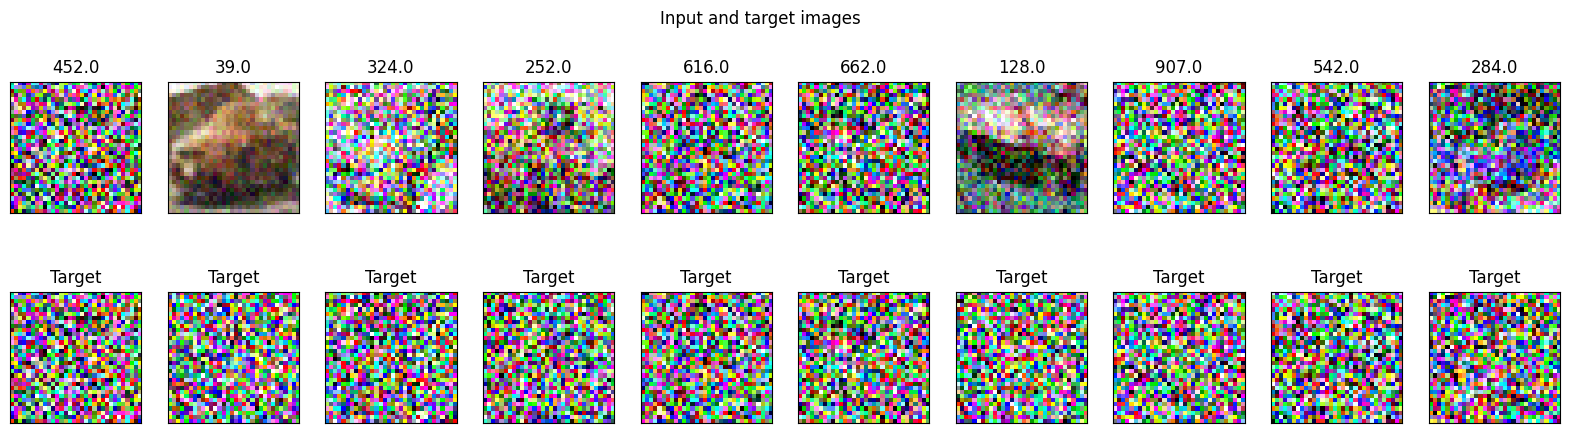

In [22]:
def generate_input_target(batch, schedule):
    # Generate random timesteps for each image in the batch
    B = batch.size(0)  # Batch size
    timesteps = torch.randint(0, schedule.num_steps + 1, (B, 1), device=batch.device)

    # Generate random noise for each image in the batch
    noise = torch.randn_like(batch)

    # Compute noised images using the forward diffusion formula
    sqrtab = schedule.sqrtab[timesteps].view(B, 1, 1, 1)
    sqrtmab = schedule.sqrtmab[timesteps].view(B, 1, 1, 1)
    noised_batch = sqrtab * batch + sqrtmab * noise

    return noised_batch, noise, timesteps.float()


# visualise 4 input and target images
vis = Visualizer(num_rows=2, num_cols=10, figsize=(20, 5), axis_off=True, title='Input and target images')
batch, _ = next(iter(train_loader))
input_imgs, targets, timesteps = generate_input_target(batch, schedule)

input_imgs = (input_imgs*0.5+0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)
targets = (targets*0.5+0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)

for i in range(10):
    vis.add_image_subplot(0, i, input_imgs[i], title_str=f'{timesteps[i,0]}')
    vis.add_image_subplot(1, i, targets[i], title_str=f'Target')


We will first write a function to generate samples from the model that we can then use during training.
Sampling works like this:


* $x_T \sim \mathcal{N}(0,1)$
* for $t = T$ downto 1:
  * $z \sim \mathcal{N}(0,1)$ if t > 1 else 0
  * $x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1 - \bar{\alpha}_t}}f(x_t, t) \right) + \sqrt{\beta_t}z $

Here $f(x_t, t)$ is the model. It takes as input the current sample and the timestep $t$. The loop terminates with $x_0$ which is the final sample.

We will "test" this function by running it with a randomly initialised model. This will not show us much but checks if the code at least runs :) ...


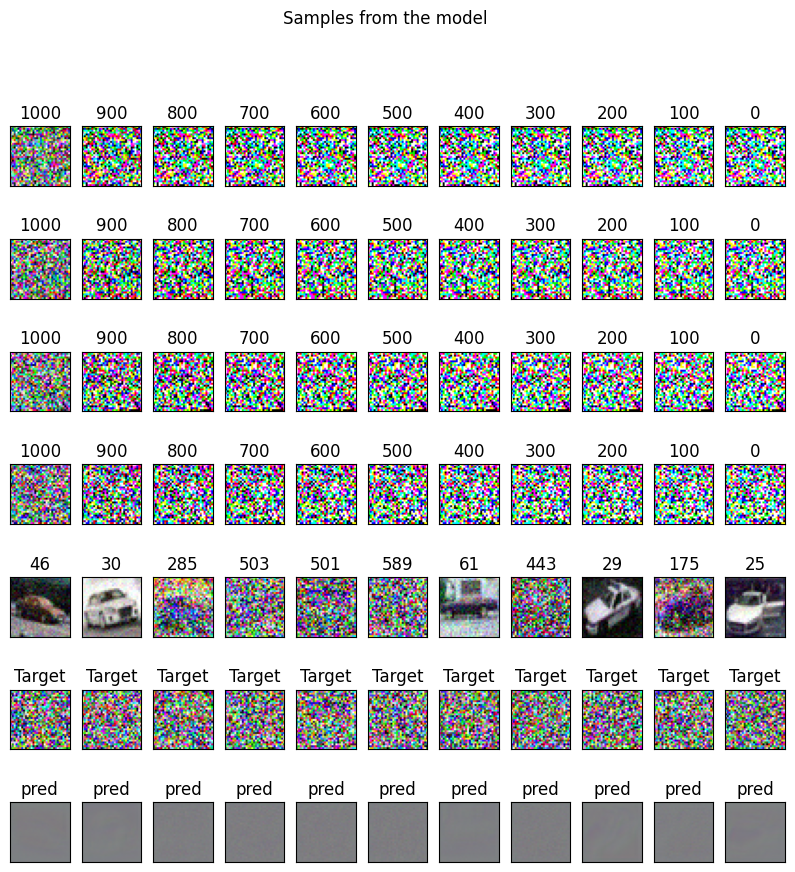

In [25]:
def sample(model, schedule):
    model.eval()
    sample = torch.randn(4, 3, 32, 32, device=schedule.device)

    vis = Visualizer(num_rows=sample.shape[0]+3, num_cols=11, figsize=(10, 10), axis_off=True, title='Samples from the model')
    with torch.no_grad():
        for i in tqdm(range(schedule.num_steps, 0, -1)):
            # TODO: compute sample
            sqrt_beta_t = schedule.sqrt_beta_t[i]
            oneover_sqrta = schedule.oneover_sqrta[i]
            mab_over_sqrtmab_inv = schedule.mab_over_sqrtmab_inv[i]

            # Predict noise with the model
            predicted_noise = model(sample, torch.tensor([i], device=schedule.device, dtype=torch.float32))

            # Generate Gaussian noise for this step
            z = torch.randn_like(sample) if i > 1 else 0  # No noise for last step

            # Compute the next sample according to the given formula
            sample = oneover_sqrta * (sample - mab_over_sqrtmab_inv * predicted_noise) + sqrt_beta_t * z


            # plotting
            if i % (schedule.num_steps // 10) == 0:
                img = (sample*0.5 + 0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)
                for j in range(sample.shape[0]):
                    vis.add_image_subplot(j, 10 - i//(schedule.num_steps // 10), img[j], title_str=f'{i}')

    # plot the final sample
    img = (sample*0.5 + 0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)
    for j in range(sample.shape[0]):
        vis.add_image_subplot(j, 10, img[j], title_str=f'{0}')

    # also show input-target-prediction triplets
    batch, _ = next(iter(train_loader))
    input_imgs, targets, timesteps = generate_input_target(batch.to(schedule.device), schedule)
    with torch.no_grad():
        pred = model(input_imgs, timesteps)
    input_imgs = (input_imgs*0.5+0.5).clip(0,1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    targets = (targets*0.5+0.5).clip(0,1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    pred = (pred*0.5+0.5).clip(0,1).cpu().detach().numpy().transpose(0, 2, 3, 1)
    for i in range(11):
        vis.add_image_subplot(sample.shape[0]+0, i, input_imgs[i], title_str=f'{int(timesteps[i,0])}')
        vis.add_image_subplot(sample.shape[0]+1, i, targets[i], title_str=f'Target')
        vis.add_image_subplot(sample.shape[0]+2, i, pred[i], title_str=f'pred')
    vis.show()

sample(Model(), Schedule(1e-4, 0.02, 1000))

Finally, we can write a training loop over multiple epochs.
We sample a batch from the dataloader and pass it to `generate_input_target` to get noised images and their corresponding noise targets.
We train the model simply with a squared loss on pixel intensities: $\| \epsilon_t - f(x_t, t) \|_2^2$.
You will need to train this model for about 500 epochs before the samples start to look like anything. Our network is too small to learn a _great_ diffusion model, but you should see some samples that resemble cars.
If possible, connect to a GPU runtime: Edit -> Notebook Settings -> T4 GPU.

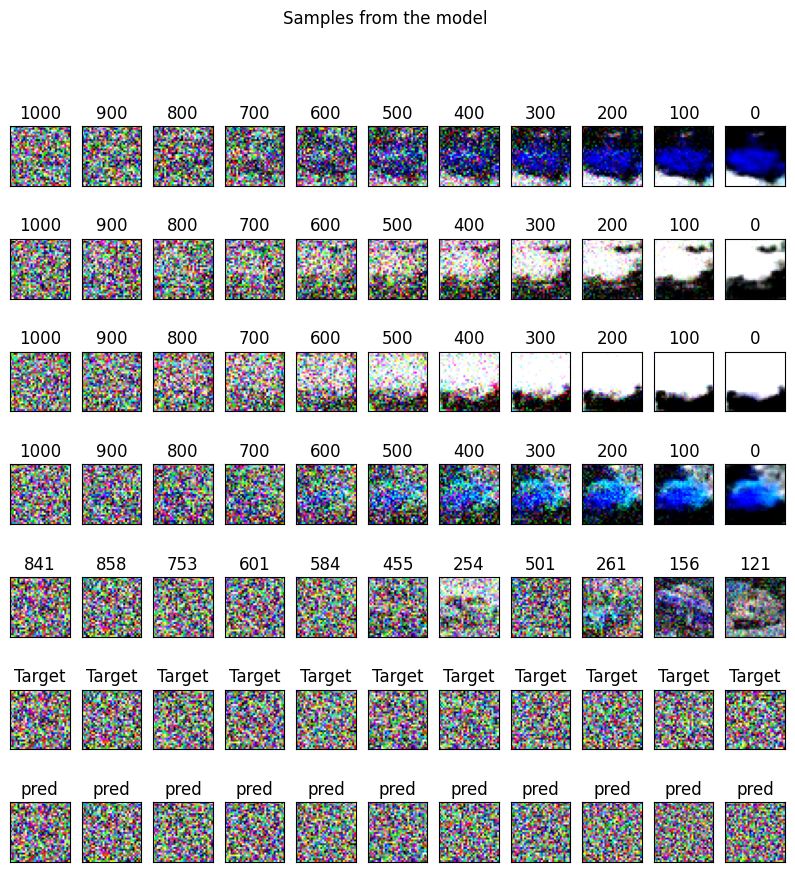

100%|██████████| 40/40 [00:02<00:00, 14.72it/s]


Epoch: 751 - Loss: 0.0540


100%|██████████| 40/40 [00:02<00:00, 16.63it/s]


Epoch: 752 - Loss: 0.0529


 30%|███       | 12/40 [00:00<00:01, 16.62it/s]

In [ ]:
device="cuda:0"  # use "cpu" or "cuda:0"
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)  # this will slowly decrease the learning rate for stabilty
schedule = Schedule(1e-4, 0.02, 1000, device)

epoch_losses = []
for epoch in range(1000):
    losses = []
    model.train()
    for batch, _ in tqdm(train_loader):
        batch = batch.to(device)

        # TODO: compute targets, and loss
        input_imgs, targets, timesteps = generate_input_target(batch, schedule)

        # Predict noise using the model
        predicted_noise = model(input_imgs, timesteps)

        # Compute the MSE loss between predicted noise and actual noise
        loss = torch.nn.functional.mse_loss(predicted_noise, targets)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    lr_scheduler.step()
    model.eval()
    print(f'Epoch: {epoch} - Loss: {np.mean(losses):.4f}')
    if epoch % 25 == 0:
        sample(model, schedule)


print('Training finished')
sample(model, schedule)

### Optional Task - Classy Diffusion
Train a class-conditional model: the model takes the class of a sample as additional input. The easiest way to do that is to change the number of input channels from 3 to 3+10. This means you need to concatenate a "one-hot" 10 channel image (where the channels of the corresponding class is all 1s and all other channels are 0). The output of the model remails a 3 channel image.

In [ ]:
import torch
import torch.nn as nn

class ConditionalModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, out_channels=3):
        super().__init__()
        # Modify input channels to 3 + 10 (RGB + class embedding)
        self.in_channels = in_channels + num_classes
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(self.in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(128, 32, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
        ])
        self.final_conv1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.final_conv2 = nn.Conv2d(16, out_channels, kernel_size=3, padding=1)
        self.act = nn.LeakyReLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, timestep, class_labels):
        # Create a one-hot encoded tensor for class labels
        B, _, H, W = x.shape
        class_one_hot = torch.zeros((B, 10, H, W), device=x.device)
        class_one_hot.scatter_(1, class_labels.view(B, 1, 1, 1).expand(B, 10, H, W), 1)

        # Concatenate class information with input image
        x = torch.cat([x, class_one_hot], dim=1)

        # Forward pass through the network
        skips = []
        for i, layer in enumerate(self.down_layers):
            x = self.act(layer(x))
            if i < 2:
                skips.append(x)
                x = self.downscale(x)

        for i, layer in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x = torch.cat([x, skips.pop()], axis=1)
            x = self.act(layer(x))

        x = self.act(self.final_conv1(x))
        x = self.final_conv2(x)
        return x


In [ ]:
def sample(model, schedule):
    model.eval()
    sample = torch.randn(4, 3, 32, 32, device=schedule.device)
    class_labels = torch.randint(0, 10, (4,), device=schedule.device)  # Random class labels

    with torch.no_grad():
        for i in tqdm(range(schedule.num_steps, 0, -1)):
            sqrt_beta_t = schedule.sqrt_beta_t[i]
            oneover_sqrta = schedule.oneover_sqrta[i]
            mab_over_sqrtmab_inv = schedule.mab_over_sqrtmab_inv[i]

            # Predict noise with the model, using class labels
            predicted_noise = model(sample, torch.tensor([i], device=schedule.device, dtype=torch.float32), class_labels)

            z = torch.randn_like(sample) if i > 1 else 0
            sample = oneover_sqrta * (sample - mab_over_sqrtmab_inv * predicted_noise) + sqrt_beta_t * z


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = ConditionalModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
schedule = Schedule(1e-4, 0.02, 1000, device)

epoch_losses = []
for epoch in range(1000):
    losses = []
    model.train()
    for batch, labels in tqdm(train_loader):
        batch = batch.to(device)
        labels = labels.to(device)

        # Generate noised images, original noise, and timesteps
        input_imgs, targets, timesteps = generate_input_target(batch, schedule)

        # Predict noise using the model (with class labels)
        predicted_noise = model(input_imgs, timesteps, labels)

        # Compute the MSE loss between predicted noise and actual noise
        loss = torch.nn.functional.mse_loss(predicted_noise, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    lr_scheduler.step()
    avg_loss = np.mean(losses)
    epoch_losses.append(avg_loss)
    print(f'Epoch: {epoch} - Loss: {avg_loss:.4f}')

    if epoch % 25 == 0:
        sample(model, schedule)

print('Training finished')
sample(model, schedule)
